In [5]:
!git clone "https://github.com/timesler/facenet-pytorch.git"

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1181 (delta 16), reused 10 (delta 2), pack-reused 1143
Receiving objects: 100% (1181/1181), 22.61 MiB | 8.37 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [8]:
!unzip -qq "face_train.zip"

In [ ]:
!rm -rf "face_train"

In [2]:
from facenet_pytorch.models.inception_resnet_v1 import InceptionResnetV1

In [23]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 30.6MB/s 
  Found existing installation: torch 1.5.0
    Uninstalling torch-1.5.0:
      Successfully uninstalled torch-1.5.0
  Found existing installation: torchvision 0.6.0
    Uninstalling torchvision-0.6.0:
      Successfully uninstalled torchvision-0.6.0


In [1]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models

import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm

import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [3]:
torch.__version__

'1.5.0+cu101'

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'face_train'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['Amer_Miracle', 'Dinesh_K', 'Sahal_K', 'Siva_Sankar', 'Suparna_S']

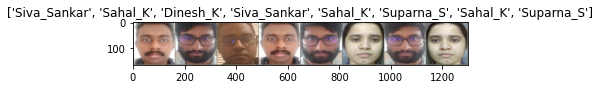

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

Running on device: cuda


In [7]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [8]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])
for param in model_ft.parameters():
    param.requires_grad = False

In [9]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [10]:
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [11]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)

model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)

model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))

model_ft.softmax = nn.Softmax(dim=1)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [12]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/79
----------
train Loss: 1.5775 Acc: 0.9095
val Loss: 1.5671 Acc: 1.0000
Epoch 1/79
----------
train Loss: 1.5690 Acc: 1.0000
val Loss: 1.5684 Acc: 1.0000
Epoch 2/79
----------
train Loss: 1.5689 Acc: 1.0000
val Loss: 1.5670 Acc: 1.0000
Epoch 3/79
----------
train Loss: 1.5685 Acc: 1.0000
val Loss: 1.5662 Acc: 1.0000
Epoch 4/79
----------
train Loss: 1.5687 Acc: 0.9984
val Loss: 1.5666 Acc: 1.0000
Epoch 5/79
----------
train Loss: 1.5689 Acc: 0.9921
val Loss: 1.5672 Acc: 1.0000
Epoch 6/79
----------
train Loss: 1.5694 Acc: 0.9984
val Loss: 1.5669 Acc: 1.0000
Epoch 7/79
----------
train Loss: 1.5690 Acc: 0.9984
val Loss: 1.5665 Acc: 1.0000
Epoch 8/79
----------
train Loss: 1.5694 Acc: 1.0000
val Loss: 1.5671 Acc: 1.0000
Epoch 9/79
----------
train Loss: 1.5687 Acc: 1.0000
val Loss: 1.5660 Acc: 1.0000
Epoch 10/79
----------
train Loss: 1.5689 Acc: 0.9968
val Loss: 1.5666 Acc: 1.0000
Epoch 11/79
----------
train Loss: 1.5694 Acc: 0.9968
val Loss: 1.5659 Acc: 1.0000
Epoch 12/79
--

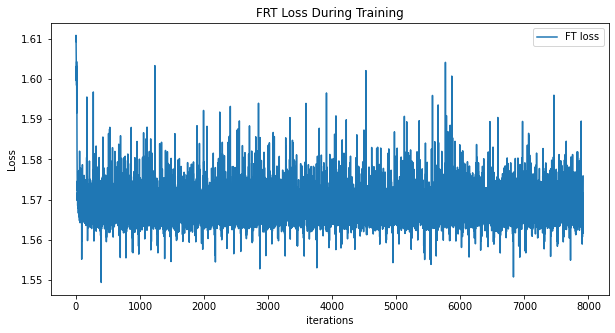

In [13]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=80)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
!wget 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
!bzip2 -dk '/content/shape_predictor_68_face_landmarks.dat.bz2'

--2020-08-22 15:50:25--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M   522KB/s    in 14s     

2020-08-22 15:50:39 (4.31 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [15]:
def get_faces(img, face_detector, face_landmark_predictor):
  face_rects = face_detector(img, 2)
  faces = []
  
  face_img = img.copy()
  H, W, _ = face_img.shape

  if len(face_rects) < 1:
    return faces

  for i, face_rect in enumerate(face_rects):
    left, top, right, bottom = face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()

    rect = dlib.rectangle(left, top, right, bottom)
    landmarks = face_landmark_predictor(img, rect)

    top_left = (left, top)
    bottom_right = (right, bottom)
    
    face_img = cv2.rectangle(face_img, top_left, bottom_right, color=(255, 255, 0), thickness=2) 
    
    border = int(2 * min(abs(top - bottom), abs(left - right)))
    # border = 0
    top_crop = top - border if top - border > 0 else 0
    bottom_crop = bottom + border if bottom + border < H else H 
    left_crop = left - border if left - border > 0 else 0
    right_crop = right + border if right + border < W else W

    img_rect = face_img[top_crop:bottom_crop, left_crop:right_crop]

    landmarks_offsetted = []
    landmarks_actual = []
    for i, landmark in enumerate(landmarks.parts()):
      x, y, = landmark.x, landmark.y
      landmarks_actual.append((x, y))
      landmarks_offsetted.append((x, y))
      img_rect = cv2.circle(img_rect, (x, y), radius=1, color=(255, 0, 0), thickness=2)

    faces.append({'idx': i, 
                  'rect_xy': (left, top, right, bottom), 
                  'rect_xy_offsetted': (left_crop, top_crop, right_crop, bottom_crop), 
                  'landmarks_offsetted': landmarks_offsetted,
                  'landmarks': landmarks_actual,
                  'img': img,
                  'rect': img[top_crop:bottom_crop, left_crop:right_crop]})
    
    return faces

In [16]:
# Normalizes a facial image to a standard size given by outSize.
# Normalization is done based on Dlib's landmark points passed as pointsIn
# After normalization, left corner of the left eye is at (0.3 * w, h/3 )
# and right corner of the right eye is at ( 0.7 * w, h / 3) where w and h
# are the width and height of outSize.
def normalize_images_and_landmarks(out_size, img_in, points_in):
  h, w = out_size

  # Corners of the eye in input image
  eyecorner_src = [points_in[36], points_in[45]]

  # Corners of the eye in normalized image
  eyecorner_dst = [(np.int(0.3 * w), np.int(h/3)), 
                  (np.int(0.7 * w), np.int(h/3))]
  
  # Calculate similarity transform
  tform = similarity_transform(eyecorner_src, eyecorner_dst)

  # Apply similarity transform to input image
  img_out = cv2.warpAffine(img_in, tform, (w, h))

  # reshape points_in from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(points_in, (points_in.shape[0], 1, points_in.shape[1]))
  
  # Apply similarity transform to landmarks
  points_out = cv2.transform(points2, tform)

  # reshape points_out to numLandmarks x 2
  points_out = np.reshape(points_out, (points_in.shape[0], points_in.shape[1]))

  return img_out, points_out

In [17]:
# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarity_transform(in_points, out_points):
  s60 = math.sin(60 * math.pi / 180)
  c60 = math.cos(60 * math.pi / 180)

  in_pts = np.copy(in_points).tolist()
  out_pts = np.copy(out_points).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(in_pts[0][0] - in_pts[1][0]) - s60*(in_pts[0][1] - in_pts[1][1]) + in_pts[1][0]
  yin = s60*(in_pts[0][0] - in_pts[1][0]) + c60*(in_pts[0][1] - in_pts[1][1]) + in_pts[1][1]

  in_pts.append([np.int(xin), np.int(yin)])

  xout = c60*(out_pts[0][0] - out_pts[1][0]) - s60*(out_pts[0][1] - out_pts[1][1]) + out_pts[1][0]
  yout = s60*(out_pts[0][0] - out_pts[1][0]) + c60*(out_pts[0][1] - out_pts[1][1]) + out_pts[1][1]

  out_pts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  # tform = cv2.estimateRigidTransform(np.array([in_pts]), np.array([out_pts]), False)
  tform, _ = cv2.estimateAffinePartial2D(np.array([in_pts]), np.array([out_pts]), False)

  # tform = cv2.getAffineTransform(eyecorner_src, eyecorner_dst)
  # tform = cv2.getAffineTransform(np.array([in_pts], dtype=np.float32), np.array([out_pts], dtype=np.float32))
  return tform

In [19]:
PREDICTOR_PATH = '/content/shape_predictor_68_face_landmarks.dat'
face_detector = dlib.get_frontal_face_detector()
face_landmark_predictor = dlib.shape_predictor(PREDICTOR_PATH)
img = cv2.imread('/content/miracle.jpeg')

def get_aligned_faces(img):
  faces = get_faces(img, face_detector, face_landmark_predictor)
  face_extracted = faces[0]
  h, w, _ = face_extracted['img'].shape
  face_in = np.float32(face_extracted['img']) / 255.0
  img_out, points_out = normalize_images_and_landmarks((h, w), face_in, np.array(face_extracted['landmarks']))
  img_out = np.uint8(img_out * 255)
  return img_out, points_out

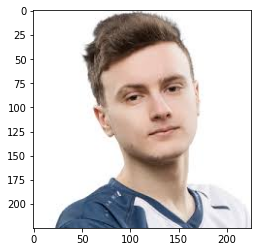

In [20]:
img_out, _ = get_aligned_faces(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
plt.imshow(img)

In [24]:
y

tensor([[0.2253, 0.1981, 0.1858, 0.1885, 0.2023]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [21]:
class_names

['Amer_Miracle', 'Dinesh_K', 'Sahal_K', 'Siva_Sankar', 'Suparna_S']

In [22]:
model_ft.eval()
x = data_transforms['val'](img).unsqueeze(dim=0)
# x = torch.from_numpy(img).unsqueeze(dim=0)
x = x.to(device)
model_ft.to(device)
y = model_ft(x)
_, preds = torch.max(y, 1)
preds[0].item(), class_names[preds]

(0, 'Amer_Miracle')

In [25]:
class_names

['Amer_Miracle', 'Dinesh_K', 'Sahal_K', 'Siva_Sankar', 'Suparna_S']

In [26]:
sample_input_cpu = torch.randn(1, 3, 224, 224).to('cpu')
model_cpu = model_ft.to('cpu')
model_cpu = torch.jit.trace(model_cpu, sample_input_cpu)
torch.jit.save(model_cpu, 'facenet_custom.pth')

In [28]:
model = torch.jit.load('facenet_custom.pth')
model

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(
    original_name=BasicConv2d
    (conv): RecursiveScriptModule(original_name=Conv2d)
    (bn): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
  )
  (1): RecursiveScriptModule(
    original_name=BasicConv2d
    (conv): RecursiveScriptModule(original_name=Conv2d)
    (bn): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
  )
  (2): RecursiveScriptModule(
    original_name=BasicConv2d
    (conv): RecursiveScriptModule(original_name=Conv2d)
    (bn): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
  )
  (3): RecursiveScriptModule(original_name=MaxPool2d)
  (4): RecursiveScriptModule(
    original_name=BasicConv2d
    (conv): RecursiveScriptModule(original_name=Conv2d)
    (bn): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveS

In [29]:
torch.__version__

'1.5.0+cu101'